In [145]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import col, when, count
from PIL import Image
import os


In [146]:
spark = SparkSession.builder.appName("Preprocessing").getOrCreate()

In [147]:
df = spark.read.csv('../data/socal2.csv', inferSchema= True, header= True)

In [148]:
df.show()

+--------+--------------------+----------------+------+---+----+----+-------+
|image_id|              street|            citi|n_citi|bed|bath|sqft|  price|
+--------+--------------------+----------------+------+---+----+----+-------+
|       0|1317 Van Buren Av...| Salton City, CA|   317|  3| 2.0|1560| 201900|
|       1|      124 C Street W|     Brawley, CA|    48|  3| 2.0| 713| 228500|
|       2|     2304 Clark Road|    Imperial, CA|   152|  3| 1.0| 800| 273950|
|       3|  755 Brawley Avenue|     Brawley, CA|    48|  3| 1.0|1082| 350000|
|       4|2207 R Carrillo C...|    Calexico, CA|    55|  4| 3.0|2547| 385100|
|       5|  755 Brawley Avenue|     Brawley, CA|    48|  3| 1.0|1082| 350000|
|       6| 1100 CAMILIA Street|    Calexico, CA|    55|  4| 3.0|2769| 415000|
|       7| 803 Chaparral Court|     Brawley, CA|    48|  5| 2.1|2600| 545000|
|       8| 803 Chaparral Court|     Brawley, CA|    48|  5| 2.1|2600| 545000|
|       9|     2306 Lark Court| Salton City, CA|   317|  4| 5.1|

In [149]:
df.printSchema()

root
 |-- image_id: integer (nullable = true)
 |-- street: string (nullable = true)
 |-- citi: string (nullable = true)
 |-- n_citi: integer (nullable = true)
 |-- bed: integer (nullable = true)
 |-- bath: double (nullable = true)
 |-- sqft: integer (nullable = true)
 |-- price: integer (nullable = true)



In [150]:
df.select(
    [count(
        when(col(c).isNull(), 1)
    ).alias(f"{c}_num_null_value") for c in df.columns]
).show()

+-----------------------+---------------------+-------------------+---------------------+------------------+-------------------+-------------------+--------------------+
|image_id_num_null_value|street_num_null_value|citi_num_null_value|n_citi_num_null_value|bed_num_null_value|bath_num_null_value|sqft_num_null_value|price_num_null_value|
+-----------------------+---------------------+-------------------+---------------------+------------------+-------------------+-------------------+--------------------+
|                      0|                    0|                  0|                    0|                 0|                  0|                  0|                   0|
+-----------------------+---------------------+-------------------+---------------------+------------------+-------------------+-------------------+--------------------+



In [151]:
# Chuyển đổi kiểu dữ liệu cột bath thành int
df = df.withColumn('bath', col= col('bath').cast('int'))

In [152]:
df.count()

15474

In [153]:
# xử lý giá trị bị trùng lặp
columns = df.columns
df = df.drop_duplicates(columns[1:]).orderBy(columns[0])
df.show()
df.count()

+--------+--------------------+-------------------+------+---+----+----+-------+
|image_id|              street|               citi|n_citi|bed|bath|sqft|  price|
+--------+--------------------+-------------------+------+---+----+----+-------+
|       0|1317 Van Buren Av...|    Salton City, CA|   317|  3|   2|1560| 201900|
|       1|      124 C Street W|        Brawley, CA|    48|  3|   2| 713| 228500|
|       2|     2304 Clark Road|       Imperial, CA|   152|  3|   1| 800| 273950|
|       3|  755 Brawley Avenue|        Brawley, CA|    48|  3|   1|1082| 350000|
|       4|2207 R Carrillo C...|       Calexico, CA|    55|  4|   3|2547| 385100|
|       6| 1100 CAMILIA Street|       Calexico, CA|    55|  4|   3|2769| 415000|
|       7| 803 Chaparral Court|        Brawley, CA|    48|  5|   2|2600| 545000|
|       9|     2306 Lark Court|    Salton City, CA|   317|  4|   5|3932| 690000|
|      10|38833 Gorman Post...|         Gorman, CA|   129|  3|   2|4044|1350000|
|      11|8072 Cuddy Valley.

12474

In [154]:
# xử lý hình ảnh
# từ images_id lấy những file có tên images_id trong images_folder_path
# lọc bỏ những hình ảnh lỗi có kích thước quá nhỏ, và lấy những hình ảnh có cùng kích thước (loại bỏ nhiễu kích thước), lấy ảnh có size = mode(image_size)  

images_folder_path = "../data/socal2/socal_pics/"

images_id = df.select('image_id').collect()
print(type(images_id))

<class 'list'>


In [155]:
# lấy danh sách image
images_path = []
dimension_image = []
list_width = []
list_height = []

for id in images_id:
    path = images_folder_path+str(id[0]) + '.jpg'
    images_path.append(path)
    # lấy kích thước của các ảnh
    
# Lấy dung lượng file (bytes → KB → MB)
    size_in_bytes = os.path.getsize(path)
    size_in_kb = size_in_bytes / 1024
    with Image.open(path) as image:
        
        width, height = image.size
        list_width.append(width)
        list_height.append(height)
        
        dimension_image.append((id[0],(width, height), size_in_kb))  

In [156]:
import pandas as pd
mode_width = pd.DataFrame(list_width)[0].mode().values
mode_height = pd.DataFrame(list_height)[0].mode().values
print(f"({mode_width},{mode_height})")

([415],[311])


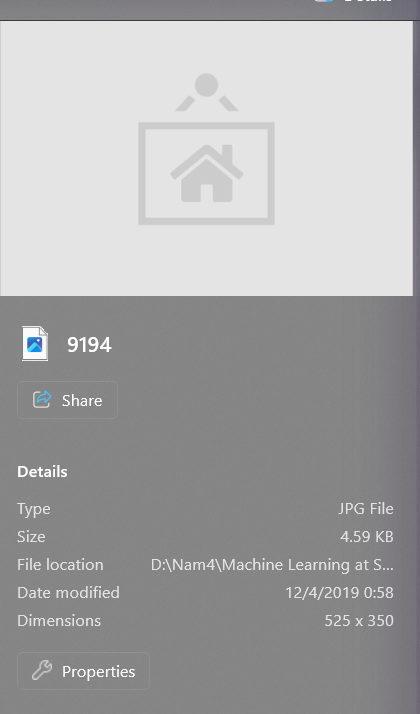

In [157]:
# loại bỏ những image có kích thước khác mode và những image có kích thước nhỏ thường có kích thước nhỏ hơn 5 kb trong tập
image_id_dropped = []
for item in dimension_image:
    id = item[0]
    width, height = item[1]
    size = item[2]
    if width != mode_width or height != mode_height or size < 6:
        image_id_dropped.append(id)
print(len(image_id_dropped))   
type(image_id_dropped[0]) 

146


int

In [158]:
# cập nhật trong df loại bỏ những row có id mà hình ảnh không thỏa mã,
df = df.select("*").where(~col('image_id').isin(image_id_dropped))


In [159]:
df.show()
df.count()

+--------+--------------------+-------------------+------+---+----+----+-------+
|image_id|              street|               citi|n_citi|bed|bath|sqft|  price|
+--------+--------------------+-------------------+------+---+----+----+-------+
|       1|      124 C Street W|        Brawley, CA|    48|  3|   2| 713| 228500|
|       2|     2304 Clark Road|       Imperial, CA|   152|  3|   1| 800| 273950|
|       3|  755 Brawley Avenue|        Brawley, CA|    48|  3|   1|1082| 350000|
|       4|2207 R Carrillo C...|       Calexico, CA|    55|  4|   3|2547| 385100|
|       6| 1100 CAMILIA Street|       Calexico, CA|    55|  4|   3|2769| 415000|
|       7| 803 Chaparral Court|        Brawley, CA|    48|  5|   2|2600| 545000|
|       9|     2306 Lark Court|    Salton City, CA|   317|  4|   5|3932| 690000|
|      10|38833 Gorman Post...|         Gorman, CA|   129|  3|   2|4044|1350000|
|      11|8072 Cuddy Valley...|   Frazier Park, CA|   122|  5|   5|6247|1499000|
|      12|  818 155th Street

12328

In [160]:
df.write.csv("../data/cleaned_data/", header=True, mode="overwrite")
